<a href="https://colab.research.google.com/github/DaeSeokSong/image-processing/blob/feature%2FPreprocessing/%5BModel_Tester%5D_Down_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Error Solution**




In [ ]:
"""
RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

[https://min23th.tistory.com/22]
"""

import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html

"""
Error solution 2.

This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
"""
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

"""
Error solution 3.

When "dice loss" is a negative number

Verify normalization when __getitem__ data from a custom dataset model that inherits Pythorch (nn.Module)
"""

# **Next step**

1. UNet++ 참조하여 모델 개선
2. ResUNet++ 참조하여 모델 개선

# ***Reference***

* *Paper*
>   [U-net](https://paperswithcode.com/paper/u-net-convolutional-networks-for-biomedical)
>
> 기존 CNN은 Single classification task에 사용되었지만,
> 
> biomedical image processing 분야에서는 한 이미지 내의 모든 pixel을 classification 하는 Semantic segmentation task가 중요하게 사용되었다.
>
>  sliding window 방식을 사용하는 CNN 구조와 달리 검증된 patch는 넘기기 때문에 보다 빠른 처리가 가능한 구조이다.
> 
> 적은 양의 데이터로도 dataset argumentation을 통해 잘 학습시킬 수 있다.
>
>   * [U-net++](https://paperswithcode.com/paper/unet-a-nested-u-net-architecture-for-medical)
>   * [ResUNet++](https://paperswithcode.com/paper/resunet-an-advanced-architecture-for-medical)

<br>

* *Lecture*
> * [UNet architecture by pytorch](https://89douner.tistory.com/300)



# **1.Development enviroment**

## *1) Import*

### 1-1) Library

In [1]:
# U-net
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms

from collections import OrderedDict

# Image processing
import cv2
import numpy as np
import pickle as pl
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
from google.colab import output

from PIL import Image

# ETC
import os
import time
import math
import shutil
import random

### 1-2) Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/Models/Surgical-Wound_Segmentation
!ls -al

/content/gdrive/MyDrive/Models/Surgical-Wound_Segmentation
total 11952
drwx------ 2 root root     4096 Sep 14 08:50 'Case Report'
drwx------ 2 root root     4096 Aug 16 08:53  Dataset
drwx------ 2 root root     4096 Sep 25 16:33 '# Lagacy'
drwx------ 2 root root     4096 Aug 17 05:49  Log
-rw------- 1 root root  1427029 Sep 30 07:45 '[Model Tester] Down Sampling.ipynb'
-rw------- 1 root root    94136 Oct  1 16:59  Preprocessor.ipynb
drwx------ 2 root root     4096 Sep 14 06:04 'Raw Dataset'
-rw------- 1 root root 10696683 Oct  1 17:03 'Surgical-Wound UNet.ipynb'


# **2.Train U-Net**

## *1) Grobal variable*

In [14]:
# Path
MODEL_PATH = "/content/gdrive/MyDrive/Models/Surgical-Wound_Segmentation"

DATASET_PATH = "/Dataset"
LOG_PATH = "/Log"
CHECK_POINT_PATH = '/CheckPoint'

TRAIN_PATH = "/train"
VAL_PATH = "/val"
TEST_PATH = "/test"

# Model parameter
NORM_INPUT_W_SIZE = 224
NORM_INPUT_H_SIZE = 224

LR = 1e-3
BATCH_SIZE = 8 # batch size 8
EPOCHS = 10 # basic == 100

"""
GPU 사용이 가능하면 cuda 사용
아니면 CPU를 이용하여 학습
"""
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("GPU use: ", torch.cuda.is_available())
print()
!nvidia-smi

GPU use:  False

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## *2) Funtion*

### 2-1) Save learned model

In [5]:
"""
[Pytorch model save tutorial]
>> https://tutorials.pytorch.kr/beginner/saving_loading_models.html
"""

# Save network
def save(ckpt_dir, net, opt, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(), 'opt':opt.state_dict()}, 
               ckpt_dir + '/model_epoch_%d.pt' %(epoch))

# Load network
def load(ckpt_dir, net, opt):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        return net, opt

    lst_ckpt = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    if len(lst_ckpt) == 0 : # 저장된 모델이 없으면 인풋 그대로 반환
        return net, opt

    lst_ckpt.sort(key = lambda f : int(f.split('.')[0].split('_')[-1]))
    dict_model = torch.load('%s/%s' % (ckpt_dir, lst_ckpt[-1]))

    net.load_state_dict(dict_model['net'])
    opt.load_state_dict(dict_model['opt'])

    return net, opt

### 2-2) Down sampling func

In [43]:
def cut_padding(image, gt_image):
    # Get grayscale image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) * 255

    # Find contours
    contours, _ = cv2.findContours(gray_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    x, y, width, height = cv2.boundingRect(contours[0])

    # Crop ROI
    image = image[y:y+height, x:x+width]
    gt_image = gt_image[y:y+height, x:x+width]

    return image, gt_image

def get_divisors(n):
    data = []

    # 약수
    divisor = 2

    # 2의 배수만을 약수로 취급
    while(divisor <= n):
        if n % divisor == 0:
            data.append(divisor)

        divisor = divisor * 2
            
    return data

def down_sampling(image, gt_image):
    # Easy Max Adaptive Sliding Window
    # 1. feature_size의 약수 중 2의 배수를 계산하여 divisors에 저장한다.
    # 2. divisors 안의 숫자 중 가장 큰수를 골라 stride라고 정의한다.
    # 3. 기준 축(anchor_axis)이 아닌 축의 길이를 slide_size라고 정의한다.
    # 4. (slide_size-feature_size) % stride를 계산하여 remain_pixel으로 정의한다.
    # 5. (slide_size-feature_size) // stride를 계산하여 step_num으로 정의한다.
    # 6. step_num이 1 미만이라면 stride를 remain_pixel로 지정한다.
    # 7. remain_pixel을 stride에 더할 extra_idx를 random으로 정한다.
    # 8. extra_random_stride != 0이라면, 각 stride에 맞게 slide window를 진행하면서 랜덤하게 적어도 1번은 해당 step의 stride에 extra_random_stride를 더한다.
    # 9. window ROI의 (전체 픽셀-noneZeroCount)를 비교하여 gt의 흰색 픽셀 비율이 10% 미만이면 건너뛴다.

    # 0.
    feature_size = 224

    # 1.
    divisors = get_divisors(224)

    # 2.
    stride = max(divisors)
    height, width, channel = image.shape

    # 3.
    if height > width:
        assert width == feature_size, "Preprocessed image width is wrong"

        anchor_axis = 'x'
        slide_size = height
    else:
        assert height == feature_size, "Preprocessed image width is height"
            
        anchor_axis = 'y'
        slide_size = width

    gt_pixel_num = cv2.countNonZero(gt_image)
    #if gt_pixel_num == 0 : return [], [], anchor_axis, {}

    # 4.
    remain_pixel = (slide_size - feature_size) % stride
    print("slide_size = ", slide_size)
    print("feature_size = ", feature_size)
    print("stride = ", stride)
    print("remain_pixel = ", remain_pixel)

    # 5.
    step_num = (slide_size - feature_size) // stride
    print("step_num = ", step_num)

    # 6.
    is_small_img = False
    if step_num < 1: 
        stride = remain_pixel
        step_num = 1
        is_small_img = True
    #if step_num < 1: return [], [], anchor_axis, {}

    # 7.
    if is_small_img:
        extra_idx = -1
    else:
        extra_idx = random.randrange(1, (step_num + 1))
    #print("extra_idx = ", extra_idx)
    #print("ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ\n")

    # 8.
    images = []
    gt_images = []
    #strides = {}
    print("step_num = ", step_num)
    for step in range(0, step_num+1):
        tmp_stride = stride

        if step == extra_idx:
            tmp_stride += remain_pixel

        #if step == 0:
        #    strides[step] = 0
        #else:
        #    strides[step] = tmp_stride

        start_idx = tmp_stride * step
        end_idx = (tmp_stride * step) + feature_size
        if step > extra_idx and extra_idx != -1:
            start_idx += remain_pixel
            end_idx += remain_pixel
        print("start_idx = ", start_idx)
        print("end_idx = ", end_idx)

        if anchor_axis == 'x':
            slide_gt = gt_image[start_idx:end_idx, :]
            gt_h, gt_w = slide_gt.shape

            if gt_h < 224: continue

            cnt_white_px = cv2.countNonZero(slide_gt)

            # 9.
            if cnt_white_px / gt_pixel_num > 0.1 or gt_pixel_num == 0:
                images.append(image[start_idx:end_idx, :, :])
                gt_images.append(slide_gt)

        elif anchor_axis == 'y':
            slide_gt = gt_image[:, start_idx:end_idx]
            gt_h, gt_w = slide_gt.shape

            if gt_w < 224: continue

            cnt_white_px = cv2.countNonZero(slide_gt)

            # 9.
            if cnt_white_px / gt_pixel_num > 0.1 or gt_pixel_num == 0:
                images.append(image[:, start_idx:end_idx, :])
                gt_images.append(slide_gt)

        else:
            assert True, "CODE ERROR, choice anchor axis"

    #return images, gt_images, anchor_axis, strides
    return images, gt_images

#### 2-2-1) Concat ground-truth samples

In [7]:
def concat_gt_samples(gt_batchs, anchor_axis, strides):
    #print("strides = ", strides)
    if anchor_axis == 'x':
        height = NORM_INPUT_H_SIZE + sum(strides.values())
        concat_output = np.zeros((height, NORM_INPUT_W_SIZE), np.uint8)
    elif anchor_axis == 'y':
        width = NORM_INPUT_W_SIZE + sum(strides.values())
        concat_output = np.zeros((NORM_INPUT_H_SIZE, width), np.uint8)
    else:
        assert anchor_axis == 'x' or anchor_axis == 'y', "[ERROR] Set Wrong Anchor Axis"

    #print("concat_output.shape = ", concat_output.shape)
    #cv2_imshow(concat_output)

    alpha = 0.5
    total_stride = 0
    for step, gt_images in enumerate(gt_batchs):
        #print("ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ")
        stride = strides[step]
        total_stride += stride
        #print("stride = ", stride)
        #print("total_stride = ", total_stride)
        for gt in gt_images:
            gt = gt.detach().numpy()
            #print("step = ", step)
            #print("gt[0].shape = ", gt[0].shape)
            #print("gt[0] = ")
            #cv2_imshow(gt[0])
            #print()
            
            if step == 0:
                if anchor_axis == 'x':
                    concat_output[0:NORM_INPUT_H_SIZE, :] = gt[0]
                if anchor_axis == 'y':
                    concat_output[: ,0:NORM_INPUT_W_SIZE] = gt[0]
            else:
                if anchor_axis == 'x':
                    concat_output_roi = concat_output[total_stride:total_stride+NORM_INPUT_H_SIZE-stride, :]
                    concat_gt = gt[0][0:NORM_INPUT_H_SIZE-stride, :]
                    #print("concat_output_roi.shape = ", concat_output_roi.shape)
                    #print("concat_gt.shape = ", concat_gt.shape)

                    concat_output_roi = cv2.addWeighted(
                        concat_output_roi, alpha,
                        concat_gt, (1-alpha), 0, dtype = cv2.CV_8UC1)
                    
                    concat_output[total_stride+(NORM_INPUT_H_SIZE-stride):total_stride+NORM_INPUT_H_SIZE, :] = gt[0][NORM_INPUT_H_SIZE-stride-1:-1, :]
                if anchor_axis == 'y':
                    concat_output_roi = concat_output[:, total_stride:total_stride+NORM_INPUT_W_SIZE-stride]
                    concat_gt = gt[0][:, 0:NORM_INPUT_W_SIZE-stride]
                    #print("concat_output_roi.shape = ", concat_output_roi.shape)
                    #print("concat_gt.shape = ", concat_gt.shape)

                    concat_output_roi = cv2.addWeighted(
                        concat_output_roi, alpha,
                        concat_gt, (1-alpha), 0, dtype = cv2.CV_8UC1)
                    
                    concat_output[:, total_stride+(NORM_INPUT_W_SIZE-stride):total_stride+NORM_INPUT_W_SIZE] = gt[0][:, NORM_INPUT_W_SIZE-stride-1:-1]

            #cv2_imshow(concat_output)
            #print()

    #print("ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ\n")
    return concat_output

### 2-3) Convenience func

In [8]:
def imshow_waitkey_enter(image):
    cv2_imshow(image)

    time.sleep(0.5)
    
    input("Please press the Enter key to proceed\n")
    os.system('clear')

    pass

## *3) Class*

### 3-1) Custom U-Net

#### 3-1-1) Architecture

**마지막 Output 채널 2 → 1 변경**
> Binary classification

<img src = "https://drive.google.com/uc?id=14CzAAaKv5v7pVfvugBRbD1xI4IuhmoyT"  width = 640>

#### 3-1-2) Build network

##### 3-1-2-1) Custom Test UNet

파라미터 문제로인한 자원 낭비 및 학습 속도 지연으로 수정 필요

In [ ]:
# torch.nn의 Module 클래스를 상속한, 커스텀 UNet 클래스
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # kernel size, stride, padding, bias는 거의 고정 >> predefine
        def ConvBatchReLU_2d(in_ch, out_ch, k_size=3, stride=1, padding=0, bias=True):
            layers = []

            # Add Conv layer
            layers += [nn.Conv2d(in_channels=in_ch,
                                 out_channels=out_ch,
                                 kernel_size=k_size,
                                 stride=stride,
                                 padding=padding,
                                 bias=bias
                                 )]

            # Add batch normalization layer
            layers += [nn.BatchNorm2d(num_features=out_ch)]

            # Add ReLU
            layers += [nn.ReLU()]

            # Define conv, ReLU step in contracting path
            CBR = nn.Sequential(*layers)

            return CBR

        """
        [Contracting path]
        >> 입력 이미지의 context 포착이 목적
        """
        # enc == encoder / n_m == n번째 stage(step)의 m번째 레이어
        self.enc1_1 = ConvBatchReLU_2d(in_ch=1, out_ch=64)
        self.enc1_2 = ConvBatchReLU_2d(in_ch=64, out_ch=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = ConvBatchReLU_2d(in_ch=64, out_ch=128)
        self.enc2_2 = ConvBatchReLU_2d(in_ch=128, out_ch=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = ConvBatchReLU_2d(in_ch=128, out_ch=256)
        self.enc3_2 = ConvBatchReLU_2d(in_ch=256, out_ch=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = ConvBatchReLU_2d(in_ch=256, out_ch=512)
        self.enc4_2 = ConvBatchReLU_2d(in_ch=512, out_ch=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = ConvBatchReLU_2d(in_ch=512, out_ch=1024)

        """
        [Expansive path]
        >> 세밀한 Localization을 위한 높은 차원의 채널을 갖는 Upsampling
        >> 얕은 레이어의 특집 맵을 결합
        """
        # dec == decoder
        self.dec5_1 = ConvBatchReLU_2d(in_ch=1024, out_ch=512)

        # up-conv 레이어는 채널을 복원을 해야하기 때문에 kernel size를
        # 대칭되는 MaxPool layer의 kernel size와 같도록 설정한다.
        self.unpool4 = nn.ConvTranspose2d(in_channels=512,
                                          out_channels=512,
                                          kernel_size=2,
                                          stride=2,
                                          padding=0,
                                          bias=True)
        
        # input channel은 up-conv와 대칭되는 enc, 두 레이어에서
        # 같은 크기의 채널로 오기 때문에 대칭 enc 레이어보다 input이 두 배 많다.
        self.dec4_2 = ConvBatchReLU_2d(in_ch=2 * 512, out_ch=512)
        self.dec4_1 = ConvBatchReLU_2d(in_ch=512, out_ch=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256,
                                          out_channels=256,
                                          kernel_size=2,
                                          stride=2,
                                          padding=0,
                                          bias=True)
        
        self.dec3_2 = ConvBatchReLU_2d(in_ch=2 * 256, out_ch=256)
        self.dec3_1 = ConvBatchReLU_2d(in_ch=256, out_ch=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128,
                                          out_channels=128,
                                          kernel_size=2,
                                          stride=2,
                                          padding=0,
                                          bias=True)
        
        self.dec2_2 = ConvBatchReLU_2d(in_ch=2 * 128, out_ch=128)
        self.dec2_1 = ConvBatchReLU_2d(in_ch=128, out_ch=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64,
                                          out_channels=64,
                                          kernel_size=2,
                                          stride=2,
                                          padding=0,
                                          bias=True)
        
        self.dec1_2 = ConvBatchReLU_2d(in_ch=2 * 64, out_ch=64)
        self.dec1_1 = ConvBatchReLU_2d(in_ch=64, out_ch=64)

        # conv 1*1, N class for segmentation
        # 이미지 상에서는 out_channels 2라 되어있으나 결과 도출을 위해 1로 설정
        self.conv = nn.Conv2d(in_channels=64,
                              out_channels=1,
                              kernel_size=1,
                              stride=1,
                              padding=0,
                              bias=True)

    """
    [Skip connection]
        >> Semantic segmentation에서는 위치정보가 중요하기에
        >> 이에 대한 소실 방지 차원에서 이전 연산했던 값을 더해준다.

        >> copy and crop
        >> encoding 데이터가 더 크므로 복사(copy)후 잘라준다(crop)
    """
    def copy_and_crop(self, enc, unpool):
        cpy_enc =  enc.clone().cpu().detach().numpy()
        diff_y = cpy_enc.shape[2] - unpool.shape[2] # height
        diff_x = cpy_enc.shape[3] - unpool.shape[3] # width

        top = int(diff_y / 2)
        left = int(diff_x / 2)
        height = int(cpy_enc.shape[2] - top)
        width = int(cpy_enc.shape[3] - left)

        if height - top > unpool.shape[2]:
            height = height - ((height - top) - unpool.shape[2])
        elif height - top < unpool.shape[2]:
            height = height + (unpool.shape[2] - (height - top))

        if width - left > unpool.shape[3]:
            width = width - ((width - left) - unpool.shape[3])
        elif width - left < unpool.shape[3]:
            width = width + (unpool.shape[3] - (width - left))

        cpy_enc = cpy_enc[:, :, top:height, left:width]
        cpy_enc = torch.Tensor(cpy_enc).to(DEVICE)

        #print("encoding size = ", cpy_enc.shape)
        #print("unpooling size = ", unpool.shape)

        return torch.cat((unpool, cpy_enc), dim=1)

    # x == input_image
    def forward(self, x):
        #print("Input size = ", x.shape)
        input_width, input_height = x.shape[2], x.shape[3]

        # encoder part
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)
        #print("enc1_1 size = ", enc1_1.shape)
        #print("enc1_2 size = ", enc1_2.shape)
        #print("pool1 size = ", pool1.shape)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)
        #print("enc2_1 size = ", enc2_1.shape)
        #print("enc2_2 size = ", enc2_2.shape)
        #print("pool2 size = ", pool2.shape)
        
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)
        #print("enc3_1 size = ", enc3_1.shape)
        #print("enc3_2 size = ", enc3_2.shape)
        #print("pool3 size = ", pool3.shape)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)
        #print("enc4_1 size = ", enc4_1.shape)
        #print("enc4_2 size = ", enc4_2.shape)
        #print("pool4 size = ", pool4.shape)

        enc5_1 = self.enc5_1(pool4)
        #print("enc5_1 size = ", enc5_1.shape)

        # decoder part
        dec5_1 = self.dec5_1(enc5_1)
        #print("dec5_1 size = ", dec5_1.shape)

        unpool4 = self.unpool4(dec5_1)
        #print("unpool4 size = ", unpool4.shape)

        cat4 = self.copy_and_crop(enc4_2, unpool4)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
        #print("cat4 size = ", cat4.shape)
        #print("dec4_2 size = ", dec4_2.shape)
        #print("dec4_1 size = ", dec4_1.shape)

        unpool3 = self.unpool3(dec4_1)
        #print("unpool3 size = ", unpool3.shape)

        cat3 = self.copy_and_crop(enc3_2, unpool3)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        #print("cat3 size = ", cat3.shape)
        #print("dec3_2 size = ", dec3_2.shape)
        #print("dec3_1 size = ", dec3_1.shape)

        unpool2 = self.unpool2(dec3_1)
        #print("unpool2 size = ", unpool2.shape)

        cat2 = self.copy_and_crop(enc2_2, unpool2)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        #print("cat2 size = ", cat2.shape)
        #print("dec2_2 size = ", dec2_2.shape)
        #print("dec2_1 size = ", dec2_1.shape)

        unpool1 = self.unpool1(dec2_1)
        #print("unpool1 size = ", unpool1.shape)

        cat1 = self.copy_and_crop(enc1_2, unpool1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        #print("cat1 size = ", cat1.shape)
        #print("dec1_2 size = ", dec1_2.shape)
        #print("dec1_1 size = ", dec1_1.shape)

        output = torch.sigmoid(self.conv(dec1_1))
        #print("Output size = ", output.shape)
        #print("Output = ", output)

        """
        output_width, output_height = x.shape[2], x.shape[3]

        # [mirroring extrapolation]
        # input(572*572)/output(388*388) 사이즈가 다르므로 output에 
        # mirroring extrapolation 기법으로 missing context 부분을 채운다.

        pad_width = int((input_width - output_width) / 2)
        pad_height = int((input_height - output_height) / 2)
        extrapolation = []
        for image in x:
            #image = nn.functional.pad(image, (pad_width, pad_width, pad_height, pad_height), 'reflect') # 이미지, (좌, 우, 상, 하), 방법
            image = nn.functional.pad(image, (pad_width, pad_width, pad_height, pad_height), 'constant', 0)
            extrapolation.append(image)

        output = torch.stack(extrapolation, dim=0).to(DEVICE)
        #print("Mirrored padding output size = ", output.shape)
        #print("Constant padding output size = ", output.shape)
        """

        return output

##### 3-1-2-2) Polar Res UNet++

In [ ]:
class UNet(nn.Module):

    def __init__(self, device, in_channels=3, out_channels=1, init_features=32): # 컬러
#    def __init__(self, device, in_channels=1, out_channels=1, init_features=32): # 흑백
        super(UNet, self).__init__()
        self.device = device
        
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
        features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
        features * 8, features * 4, kernel_size=2, stride=2
        )

        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
        features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
        features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
        in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2,), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1,), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
        OrderedDict(
            [
                (
                    name + "conv1",
                    nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=features,
                    kernel_size=3,
                    padding=1,
                    bias=False,
                    ),
                ),
                (name + "norm1", nn.BatchNorm2d(num_features=features)),
                (name + "relu1", nn.ReLU(inplace=True)),
                (
                    name + "conv2",
                    nn.Conv2d(
                    in_channels=features,
                    out_channels=features,
                    kernel_size=3,
                    padding=1,
                    bias=False,
                    ),
                ),
                (name + "norm2", nn.BatchNorm2d(num_features=features)),
                (name + "relu2", nn.ReLU(inplace=True)),
            ]
        ))

##### 3-1-2-3) Surgical-Wound UNet

***Base on Polar RES UNet++***

In [9]:
class SW_UNet(nn.Module):

    def __init__(self, device, in_channels=3, out_channels=1, init_features=32): # 컬러
#    def __init__(self, device, in_channels=1, out_channels=1, init_features=32): # 흑백
        super(SW_UNet, self).__init__()
        self.device = device

        features = init_features
        self.encoder1 = SW_UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = SW_UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = SW_UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = SW_UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = SW_UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
        features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = SW_UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
        features * 8, features * 4, kernel_size=2, stride=2
        )

        self.decoder3 = SW_UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
        features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = SW_UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
        features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = SW_UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
        in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2,), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1,), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
        OrderedDict(
            [
                (
                    name + "conv1",
                    nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=features,
                    kernel_size=3,
                    padding=1,
                    bias=False,
                    ),
                ),
                (name + "norm1", nn.BatchNorm2d(num_features=features)),
                (name + "relu1", nn.ReLU(inplace=True)),
                (
                    name + "conv2",
                    nn.Conv2d(
                    in_channels=features,
                    out_channels=features,
                    kernel_size=3,
                    padding=1,
                    bias=False,
                    ),
                ),
                (name + "norm2", nn.BatchNorm2d(num_features=features)),
                (name + "relu2", nn.ReLU(inplace=True)),
            ]
        ))

#### 3-1-3) Dice loss

In [10]:
"""
Best dice score model of Lesion Segmentation on ISIC 2018
>> Some of them, DiceLoss code

https://github.com/marinbenc/medical-polar-training/blob/main/loss.py
https://paperswithcode.com/paper/training-on-polar-image-transformations#code
"""
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        #assert y_pred.size() == y_true.size()
        dscs = torch.zeros(y_pred.shape[1])

        for i in range(y_pred.shape[1]):
          y_pred_ch = y_pred[:, i].contiguous().view(-1)
          y_true_ch = y_true[:, i].contiguous().view(-1)

          intersection = (y_pred_ch * y_true_ch).sum()

          dscs[i] = (2. * intersection + self.smooth) / (y_pred_ch.sum() + y_true_ch.sum() + self.smooth)

        # dice_score = 1.0 - dice_loss
        return 1.0 - torch.mean(dscs)

### 3-2) Pytorch

#### 3-2-1) Dataset

In [11]:
class WoundDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_wound = [f for f in lst_data if f.startswith('wound')]
        lst_gt = [f for f in lst_data if f.startswith('gt')]

        lst_wound.sort()
        lst_gt.sort()

        self.lst_wound = lst_wound
        self.lst_gt = lst_gt

    def __len__(self):
        return len(self.lst_gt)

    def __getitem__(self, index):
        # 컬러
        wound = cv2.imread(os.path.join(self.data_dir, self.lst_wound[index]))

        # 흑백
        #wound = cv2.imread(os.path.join(self.data_dir, self.lst_wound[index]),
        #                  cv2.IMREAD_GRAYSCALE)

        gt = cv2.imread(os.path.join(self.data_dir, self.lst_gt[index]),
                          cv2.IMREAD_GRAYSCALE)

        # 정규화
        #wound = wound/255.0
        #gt = gt/255.0

        if wound.ndim == 2:
            wound = wound[:, :, np.newaxis]
        if gt.ndim == 2:
            gt = gt[:, :, np.newaxis]

        data = {'wound': wound, 'gt': gt}

        if self.transform:
            data = self.transform(data)

        return data

#### 3-2-2) Transform

In [12]:
class ToTensor(object):
    def __call__(self, data):
        wound, gt = data['wound'], data['gt']
        wound = wound.transpose((2, 0, 1)).astype(np.float32)
        gt = gt.transpose((2, 0, 1)).astype(np.float32)

        data = {'wound': torch.from_numpy(wound), 'gt': torch.from_numpy(gt)}

        return data

# Dataset arugmentation
class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        wound, gt = data['wound'], data['gt']

        wound = (wound - self.mean) / self.std
        data = {'wound': wound, 'gt': gt}

        return data

class RandomFlip(object):
    def __call__(self, data):
        wound, gt = data['wound'], data['gt']

        if np.random.rand() > 0.5:
            wound = np.fliplr(wound)
            gt = np.fliplr(gt)

        if np.random.rand() > 0.5:
            wound = np.flipud(wound)
            gt = np.flipud(gt)

        data = {'wound': wound, 'gt': gt}

        return data

## *4) Run*

### 4-1) Prepare dataset

In [16]:
#trans = transforms.Compose([Normalization(),
#                            RandomFlip(),
#                            ToTensor()])
trans = transforms.Compose([ToTensor()])

train_dataset = WoundDataset(data_dir=MODEL_PATH + DATASET_PATH + TRAIN_PATH, transform=trans)
print("train_dataset = ", len(train_dataset))

val_dataset = WoundDataset(data_dir=MODEL_PATH + DATASET_PATH + VAL_PATH, transform=trans)
print("val_dataset = ", len(val_dataset))

print("ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print("train_loader = ", len(train_loader))

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
print("val_loader = ", len(val_loader))

train_dataset =  581
val_dataset =  250
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
train_loader =  73
val_loader =  32


### 4-2) Set variable about training

In [17]:
# 커스텀
#net = UNet().to(DEVICE)

# Poloar Res UNet++
#net = UNet(DEVICE).to(DEVICE)

# Surgical-Wound UNet
net = SW_UNet(DEVICE).to(DEVICE)

# before used Loss, nn.BCEWithLogitsLoss().to(DEVICE)
criterion = DiceLoss().to(DEVICE)

# Set optimizer
opt = torch.optim.Adam(net.parameters(), lr=LR)

num_batch_train = len(train_loader)
num_batch_val = len(val_loader)

# Set lambda func
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

# Set SummaryWriter
if not os.path.exists(MODEL_PATH + LOG_PATH + TRAIN_PATH):
    os.makedirs(MODEL_PATH + LOG_PATH + TRAIN_PATH)

if not os.path.exists(MODEL_PATH + LOG_PATH + VAL_PATH):
    os.makedirs(MODEL_PATH + LOG_PATH + VAL_PATH)

writer_train = SummaryWriter(log_dir=MODEL_PATH + LOG_PATH + TRAIN_PATH)
writer_val = SummaryWriter(log_dir=MODEL_PATH + LOG_PATH + VAL_PATH)

### 4-3) Train model

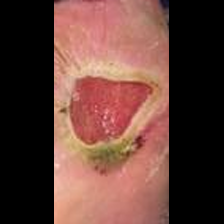

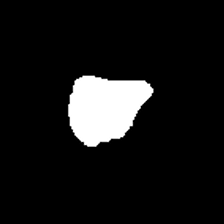

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ





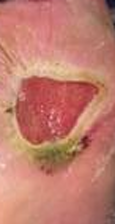

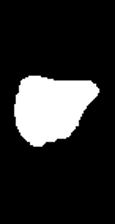

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ



target_wound.shape =  (436, 224, 3)


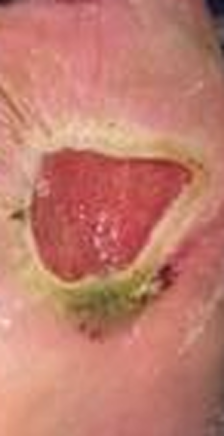

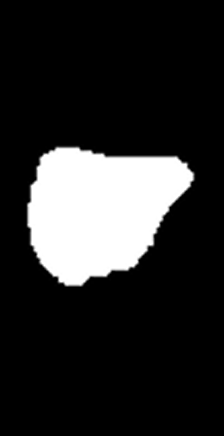

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

slide_size =  436
feature_size =  224
stride =  32
remain_pixel =  20
step_num =  6
step_num =  6
start_idx =  0
end_idx =  224
start_idx =  32
end_idx =  256
start_idx =  104
end_idx =  328
start_idx =  116
end_idx =  340
start_idx =  148
end_idx =  372
start_idx =  180
end_idx =  404
start_idx =  212
end_idx =  436
len(sampling_wound) =  7
len(sampling_gt) =  7




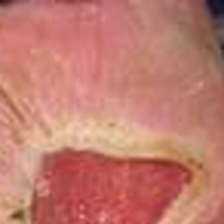

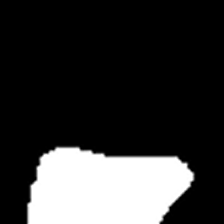

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])




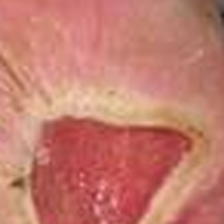

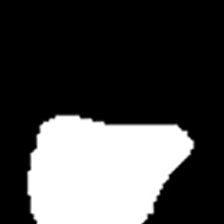

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])




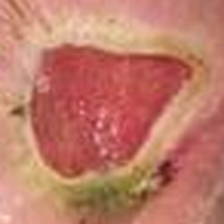

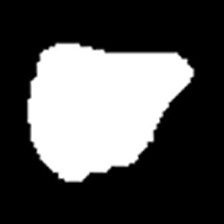

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])




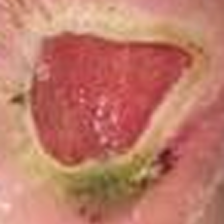

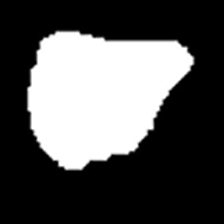

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])




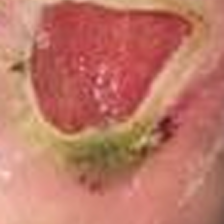

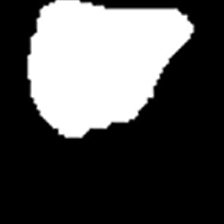

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])




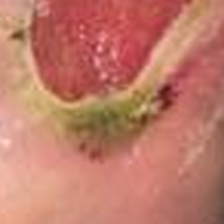

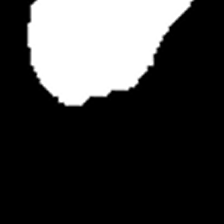

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])




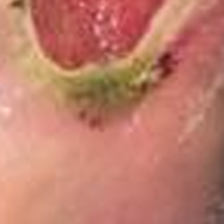

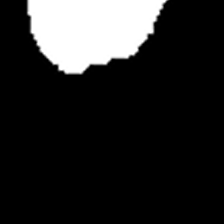

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])




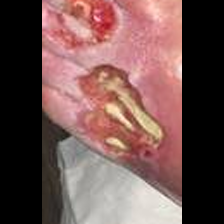

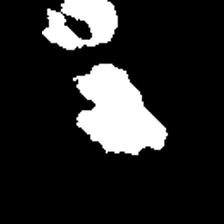

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ





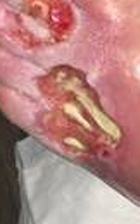

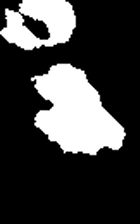

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ



target_wound.shape =  (358, 224, 3)


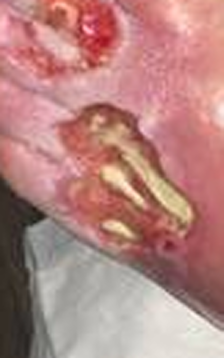

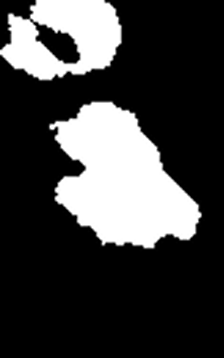

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

slide_size =  358
feature_size =  224
stride =  32
remain_pixel =  6
step_num =  4
step_num =  4
start_idx =  0
end_idx =  224
start_idx =  32
end_idx =  256
start_idx =  76
end_idx =  300
start_idx =  102
end_idx =  326
start_idx =  134
end_idx =  358
len(sampling_wound) =  5
len(sampling_gt) =  5




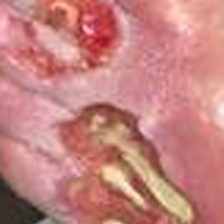

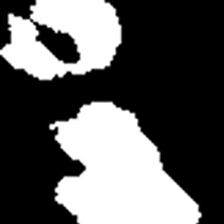

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])




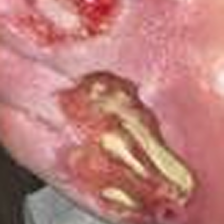

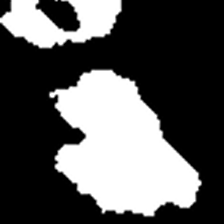

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])




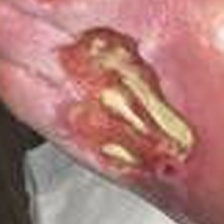

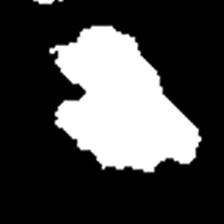

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])




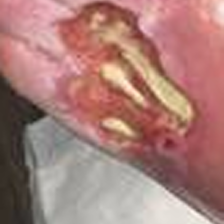

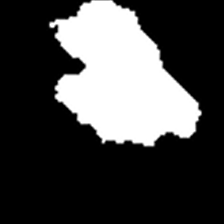

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])




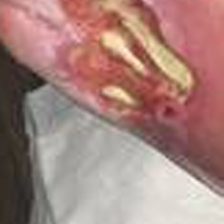

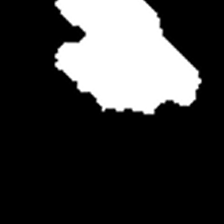

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])




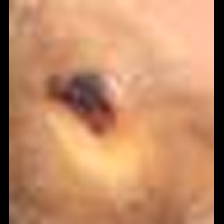

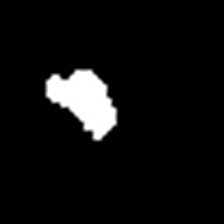

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ





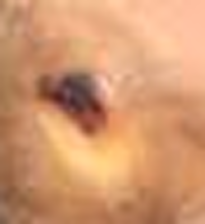

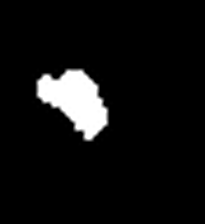

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ



target_wound.shape =  (245, 224, 3)


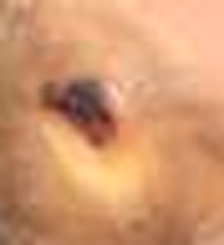

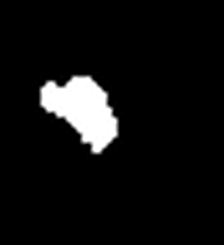

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

slide_size =  245
feature_size =  224
stride =  32
remain_pixel =  21
step_num =  0
step_num =  1
start_idx =  0
end_idx =  224
start_idx =  21
end_idx =  245
len(sampling_wound) =  2
len(sampling_gt) =  2




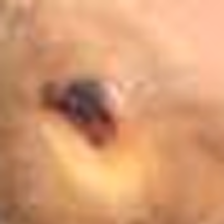

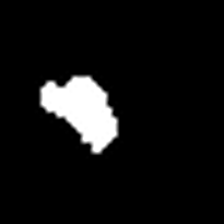

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])




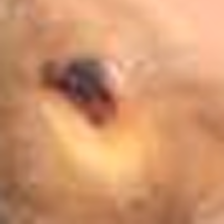

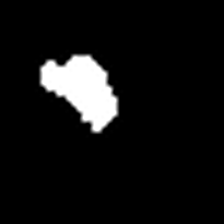

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])




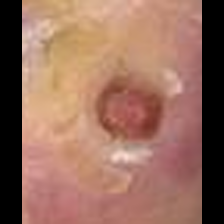

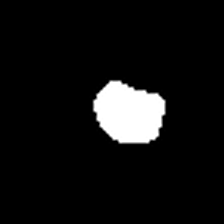

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ





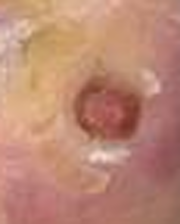

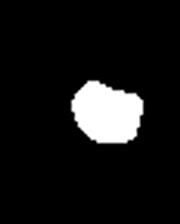

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ



target_wound.shape =  (279, 224, 3)


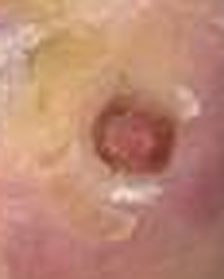

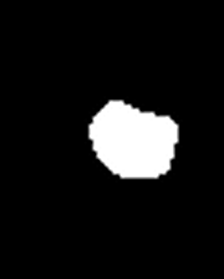

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

slide_size =  279
feature_size =  224
stride =  32
remain_pixel =  23
step_num =  1
step_num =  1
start_idx =  0
end_idx =  224
start_idx =  55
end_idx =  279
len(sampling_wound) =  2
len(sampling_gt) =  2




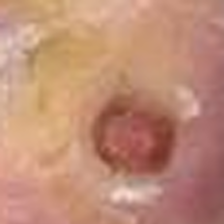

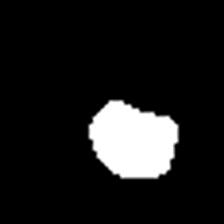

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])




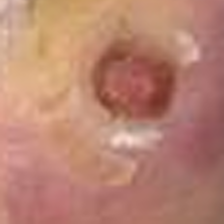

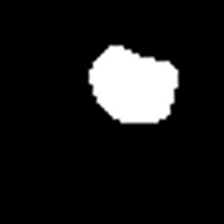

ds_image.shape =  (224, 224, 3)
ds_gt.shape =  (224, 224)
ds_image.shape =  (1, 3, 224, 224)
ds_gt.shape =  (1, 1, 224, 224)
output.shape =  torch.Size([1, 1, 224, 224])


KeyboardInterrupt: ignored

In [44]:
# Load saved model
#ckpt_dir = MODEL_PATH + CHECK_POINT_PATH
#net, opt = load(ckpt_dir, net, opt)

# Init prams
start_epoch = 0
best_train_loss = -1
best_val_loss = -1

for epoch in range(start_epoch+1, EPOCHS+1):
    net.train()
    loss_arr = []

    for batch, data in enumerate(train_loader, 1):
        # Load data
        wound = data['wound'].to(DEVICE)
        gt = data['gt'].to(DEVICE)
        #print("wound.shape = ", wound.shape)
        #print("gt.shape = ", gt.shape)

        for ds_epoch, image in enumerate(wound):
            # Get image and ground-truth
            origin_wound = image.numpy().transpose(1, 2, 0).astype('uint8')
            origin_gt = gt[ds_epoch].numpy().transpose(1, 2, 0).astype('uint8')

            print('\n')
            cv2_imshow(origin_wound)
            print('\n')
            cv2_imshow(origin_gt)
            print("ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ\n")

            # Cut padding
            target_wound, target_gt = cut_padding(origin_wound, origin_gt)

            print('\n')
            cv2_imshow(target_wound)
            print('\n')
            cv2_imshow(target_gt)
            print("ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ\n")

            # Reszie smaller side(width or height) to 224 in proportion
            get_h, get_w, get_ch = target_wound.shape

            if get_w < get_h:
                resize_scale = NORM_INPUT_W_SIZE / get_w
            else:
                resize_scale = NORM_INPUT_H_SIZE / get_h

            target_wound = cv2.resize(target_wound,
                                      (0, 0),
                                      fx=resize_scale,
                                      fy=resize_scale,
                                      interpolation=cv2.INTER_CUBIC)
            target_gt = cv2.resize(target_gt, 
                                   (0, 0),
                                   fx=resize_scale,
                                   fy=resize_scale,
                                   interpolation=cv2.INTER_CUBIC)

            print('\n')
            print("target_wound.shape = ", target_wound.shape)
            cv2_imshow(target_wound)
            print('\n')
            cv2_imshow(target_gt)
            print("ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ\n")

            # Down sampling
            #print("\n========== Down Sampling ==========\n")
            #sampling_wound, sampling_gt, anchor_axis, strides = down_sampling(target_wound, target_gt)
            sampling_wound, sampling_gt = down_sampling(target_wound, target_gt)
            print("len(sampling_wound) = ", len(sampling_wound))
            print("len(sampling_gt) = ", len(sampling_gt))
            for step, ds_image in enumerate(sampling_wound):
                print('\n')
                cv2_imshow(ds_image)
                cv2_imshow(sampling_gt[step])

                # Get down-sampled ground-truth image
                ds_gt = sampling_gt[step]
                print("ds_image.shape = ", ds_image.shape)
                print("ds_gt.shape = ", ds_gt.shape)

                # Preprocess
                    # Norm input
                ds_image = ds_image/255.0
                ds_gt = ds_gt/255.0
                    # Expand dims
                ds_image = np.expand_dims(ds_image, axis=0).transpose(0, 3, 1, 2)
                ds_gt = np.expand_dims(ds_gt, axis=0)
                ds_gt = np.expand_dims(ds_gt, axis=0)
                print("ds_image.shape = ", ds_image.shape)
                print("ds_gt.shape = ", ds_gt.shape)
                    # ToTensor
                ds_image = torch.Tensor(ds_image)
                ds_gt = torch.Tensor(ds_gt)

                # Forward
                output = net(ds_image)
                print("output.shape = ", output.shape)

                # Backward
                opt.zero_grad()

                loss = criterion(output, ds_gt)
                loss.backward()

                opt.step()

                loss_arr += [loss.item()]
            """
            if len(sampling_wound) < 1 or len(sampling_gt) < 1 or len(strides) < 1: 
                # Preprocess
                    # Norm
                origin_image = origin_wound/255.0
                origin_gt = origin_gt/255.0
                    # Expand dims
                origin_image = np.expand_dims(origin_image, axis=0).transpose(0, 3, 1, 2).astype('uint8')
                origin_gt = np.expand_dims(origin_gt, axis=0).transpose(0, 3, 1, 2).astype('uint8')
                    # ToTensor
                origin_image = torch.Tensor(origin_image)
                origin_gt = torch.Tensor(origin_gt)

                # Forward
                output = net(origin_image)

                #print("origin_output.shape = ", output.shape)
                #print("origin_gt.shape = ", origin_gt.shape)

                # Backward
                opt.zero_grad()

                loss = criterion(output, origin_gt)
                loss.backward()

                opt.step()

                loss_arr += [loss.item()]
                print(f"[total = {len(loss_arr) : 04d}] loss_arr = ", loss_arr)
                
                break

            # Concat output
            sampling_outputs = []
            for step, ds_image in enumerate(sampling_wound):
                print('\n')
                cv2_imshow(ds_image)
                cv2_imshow(sampling_gt[step])

                # Preprocess
                    # Norm input
                ds_image = ds_image/255.0
                    # Expand dims
                ds_image = np.expand_dims(ds_image, axis=0).transpose(0, 3, 1, 2)
                    # ToTensor
                ds_image = torch.Tensor(ds_image)

                # Forward
                ds_output = net(ds_image)
                sampling_outputs.append(ds_output)

            # Postprocess
                # Norm ground-truth
            target_gt = target_gt/255.0
                # Concat outputs
            output = concat_gt_samples(sampling_outputs, anchor_axis, strides)
                # Expand dims
            output = np.expand_dims(output, axis=0).transpose(1, 2, 0).astype('uint8')
            target_gt = np.expand_dims(target_gt, axis=0).transpose(1, 2, 0).astype('uint8')
                # ToTensor
            output = torch.Tensor(output)
            target_gt = torch.Tensor(target_gt)
            #print("output.shape = ", output.shape)
            #print("target_gt.shape = ", target_gt.shape)

            # Backward
            opt.zero_grad()

            loss = criterion(output, target_gt)
            loss.requires_grad_(True)
            loss.backward()

            opt.step()

            loss_arr += [loss.item()]
            print(f"[total = {len(loss_arr) : 04d}] loss_arr = ", loss_arr)
            """

    # Save loss
    print("=======================================================")
    print(f"TRAIN || EPOCH {epoch :04d} | DICE LOSS {np.mean(loss_arr) : .4f}")
    print("=======================================================")

    # Validate
    with torch.no_grad():
        net.eval()
        loss_arr = []

        for batch, data in enumerate(val_loader, 1):
            # Forward
            wound = data['wound'].to(DEVICE)
            gt = data['gt'].to(DEVICE)
            output = net(wound)

            # Print size
            if batch == math.ceil(num_batch_train):
                print("====================")
                print("Input size = ", wound.shape)
                print("ground-truth size = ", gt.shape)
                print("output size = ", output.shape)
                print("====================")

            # Calc loss
            loss = criterion(output, gt)

            # Save loss
            loss_arr += [loss.item()]
            print("=======================================================")
            print(f"VALID || EPOCH {epoch :04d} | BATCH {batch : 04d} / {math.ceil(num_batch_val) : 04d} | DICE LOSS {np.mean(loss_arr) : .4f}")
            print("=======================================================")

            # Save best loss
            if batch > math.ceil((len(val_dataset) / BATCH_SIZE) / 2) :
                if best_val_loss == -1 or np.mean(loss_arr) < best_val_loss:
                    best_val_loss = np.mean(loss_arr)

            # Save tensorboard
            gt = fn_tonumpy(gt)
            wound = fn_tonumpy(fn_denorm(wound, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

            writer_val.add_image('ground-truth', gt, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('wound', wound, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)
        print("Write train loss, epoch ", epoch)
        print()

    # Save network at epoch end
    #save(ckpt_dir, net, opt, epoch)
    print("ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ")

print("Best loss in Train = ", best_train_loss)
print("Best loss in Validation = ", best_val_loss)

writer_train.close()
writer_val.close()

### 4-4) Show train/val result

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir {MODEL_PATH + LOG_PATH}

### 4-5) Test benchmark

In [ ]:
# Set test dataset
test_dataset = WoundDataset(data_dir=MODEL_PATH + DATASET_PATH + TEST_PATH, transform=trans)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

num_batch_test = len(test_dataset) / BATCH_SIZE

# Set loss
test_criterion = DiceLoss().to(DEVICE)

# Set SummaryWriter
if not os.path.exists(MODEL_PATH + LOG_PATH + TEST_PATH):
    os.makedirs(MODEL_PATH + LOG_PATH + TEST_PATH)

writer_test = SummaryWriter(log_dir=MODEL_PATH + LOG_PATH + TEST_PATH)

# Test
with torch.no_grad():
    net.eval()
    loss_arr = []

    for batch, data in enumerate(val_loader, 1):
        # Forward
        scar = data['scar'].to(DEVICE)
        label = data['label'].to(DEVICE)
        output = net(scar)

        # Calc loss
        loss = test_criterion(output, label)

        # Save loss
        loss_arr += [loss.item()]
        print("=======================================================")
        print(f"TEST || BATCH {batch : 04d} / {math.ceil(len(test_dataset)/BATCH_SIZE) : 04d} | DICE_LOSS {np.mean(loss_arr) : .4f}")
        print("=======================================================")

        # Save tensorboard
        label = fn_tonumpy(label)
        scar = fn_tonumpy(fn_denorm(scar, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_class(output))

        writer_test.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
        writer_test.add_image('scar', scar, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
        writer_test.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

    writer_test.add_scalar('loss', np.mean(loss_arr), epoch)
    print("ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ")

### 4-6) Show test result

In [ ]:
%tensorboard --logdir {MODEL_PATH + LOG_PATH}